<a href="https://colab.research.google.com/github/NazihaCode/Card-Extraction-Data/blob/master/Segmentation_CNR_Aberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modele Segmentation du permis de conduire ouvert(CNR Aberta) 
Dataset BID (Brazilian-Identity-Document-Dataset)
https://drive.google.com/file/d/1Oi88TRcpdjZmJ79WDLb9qFlBNG8q2De6/view?usp=sharing

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPooling2D, Input, UpSampling2D, Dropout, BatchNormalization
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from google.colab.patches import cv2_imshow
from pathlib import Path
from collections import Counter

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [7]:
cd 'Card_extraction_Data/'


/content/drive/MyDrive/Card_extraction_Data


In [8]:
cd 'BID Dataset/'

/content/drive/MyDrive/Card_extraction_Data/BID Dataset


In [23]:
from pathlib import Path
CNR_Data = Path('./CNH_Aberta')

In [86]:
# Get list of all the images(sorted)
images = sorted(list(map(str, list(CNR_Data.glob("*_in.jpg")))))
print(images[1:4])

['CNH_Aberta/00000001_in.jpg', 'CNH_Aberta/00000002_in.jpg', 'CNH_Aberta/00000003_in.jpg']


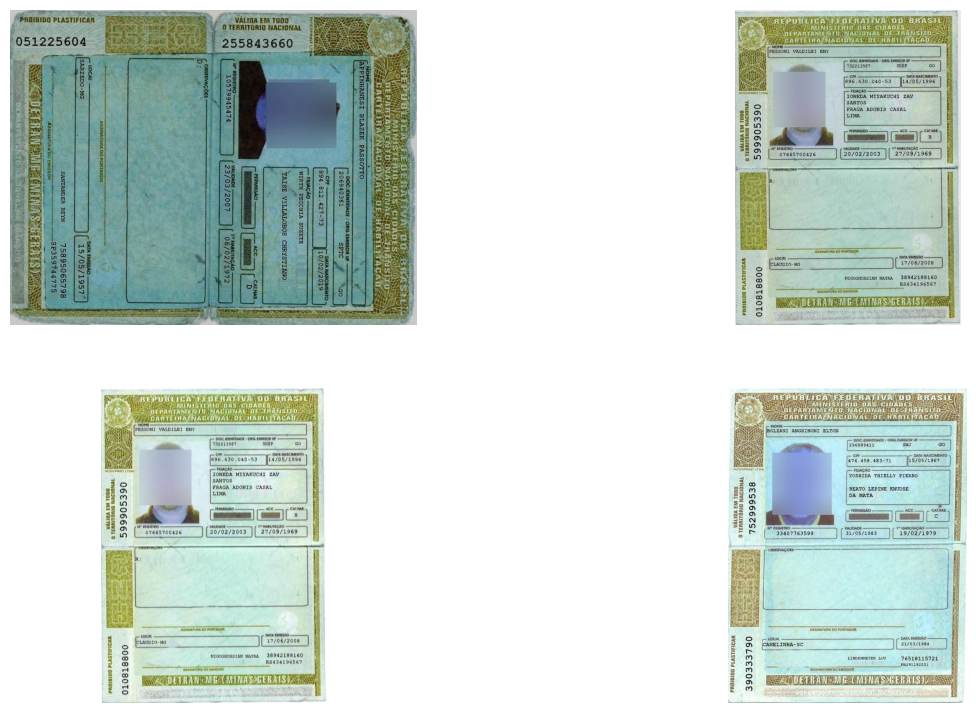

In [88]:
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(15,9))
for i in range(4):
    img = cv2.imread((sample_images[i]))
    #print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [ ]:
#list of images masks
CNR_masks = list(CNR_Data.glob("*_gt_segmentation.jpg"))
print(CNR_masks)

In [9]:
masks = sorted(list(map(str, list(CNR_Data.glob("*_gt_segmentation.jpg")))))

In [10]:
masks[1:3]

['CNH_Aberta/00000001_gt_segmentation.jpg',
 'CNH_Aberta/00000002_gt_segmentation.jpg']

In [ ]:
import pandas as pd
import numpy as np
Masks_Series = pd.Series(CNR_masks,name="CNH_Aberta").astype(str)
Masks_Series.head()

In [15]:
img_height = 64
img_width = 64
def encode_single_sample(img_path, mask_path):
    # Load image and mask
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    #img = tf.image.rgb_to_grayscale(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    # Normalize pixel values
    img = img / 255.0
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    mask = tf.image.resize(mask, [img_height, img_width])
    # Normalize pixel values
    mask = mask / 255.0
    mask = tf.transpose(mask, perm=[1, 0, 2])
    return img, mask


In [16]:
def split_data(images, masks, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    print(size)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train =(images)[indices[:train_samples]],(masks)[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], masks[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid



In [17]:
import numpy as np
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images),np.array(masks))
print(y_valid[1:4])
print(x_valid[1:4])

3600
['CNH_Aberta/00000348_gt_segmentation.jpg'
 'CNH_Aberta/00003509_gt_segmentation.jpg'
 'CNH_Aberta/00003221_gt_segmentation.jpg']
['CNH_Aberta/00000348_in.jpg' 'CNH_Aberta/00003509_in.jpg'
 'CNH_Aberta/00003221_in.jpg']


In [18]:
x_train.shape,x_valid.shape, y_train.shape, y_valid.shape

((3240,), (360,), (3240,), (360,))

In [19]:
 # Batch size for training and validation
batch_size = 128
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = ( train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [20]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>

In [21]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>

In [22]:
# Define the U-Net architecture
def unet(input_size=(64, 64, 3)):
    inputs = tf.keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bridge
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
   # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


In [23]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        #res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [26]:
epochs = 50
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)
     

Epoch 1/50
26/26 [==============================] - 698s 25s/step - loss: 0.1515 - accuracy: 0.7932 - val_loss: 0.0078 - val_accuracy: 0.7926
Epoch 2/50
26/26 [==============================] - 50s 2s/step - loss: 0.0062 - accuracy: 0.7933 - val_loss: 0.0054 - val_accuracy: 0.7926
Epoch 3/50
26/26 [==============================] - 50s 2s/step - loss: 0.0052 - accuracy: 0.7933 - val_loss: 0.0051 - val_accuracy: 0.7926
Epoch 4/50
26/26 [==============================] - 49s 2s/step - loss: 0.0051 - accuracy: 0.7933 - val_loss: 0.0051 - val_accuracy: 0.7926
Epoch 5/50
26/26 [==============================] - 49s 2s/step - loss: 0.0051 - accuracy: 0.7933 - val_loss: 0.0051 - val_accuracy: 0.7926
Epoch 6/50
26/26 [==============================] - 47s 2s/step - loss: 0.0050 - accuracy: 0.7933 - val_loss: 0.0051 - val_accuracy: 0.7926
Epoch 7/50
26/26 [==============================] - 54s 2s/step - loss: 0.0050 - accuracy: 0.7933 - val_loss: 0.0051 - val_accuracy: 0.7926
Epoch 8/50
26/26 [

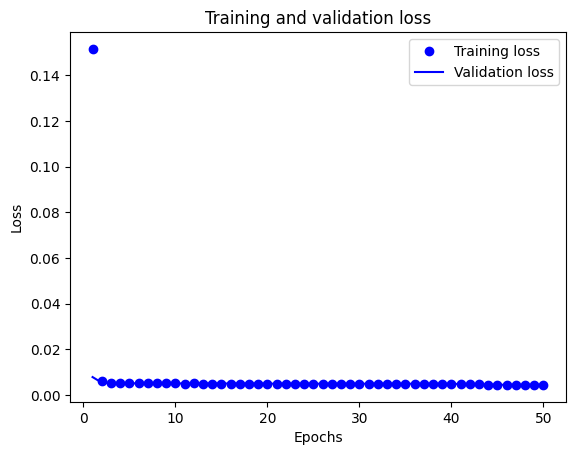

In [27]:
from matplotlib import pyplot as plt
# Plot the training and validation losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

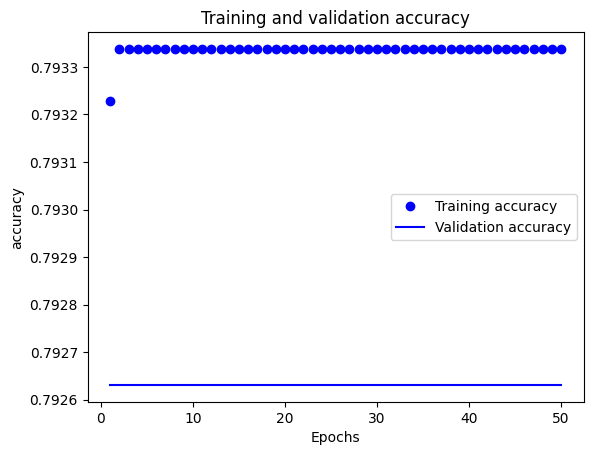

In [29]:
from matplotlib import pyplot as plt
# Plot the training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [35]:
# Exporting model
import pickle
pickle.dump(model,open('modelSegmentation.pkl','wb'))

## Prédiction

In [40]:
# Import & Predict
import pickle
model =pickle.load(open("modelSegmentation.pkl",'rb'))

In [50]:
import os
import numpy as np
import cv2
import tensorflow as tf

# Load image and mask
file = ("./BID Dataset/CNH_Aberta/00000000_in.jpg") 
img = tf.io.read_file(file)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)    
img = tf.image.resize(img, [64, 64])
# Normalize pixel values
img = img / 255.0
img = tf.transpose(img, perm=[1, 0, 2])

In [54]:
img.shape

TensorShape([64, 64, 3])

In [55]:
import numpy as np
img = np.expand_dims(img, axis=0)
predictions = model.predict(img)


1/1 [==============================] - 1s 952ms/step


In [53]:
print(model.input_shape)

(None, 64, 64, 3)


<Figure size 640x480 with 0 Axes>

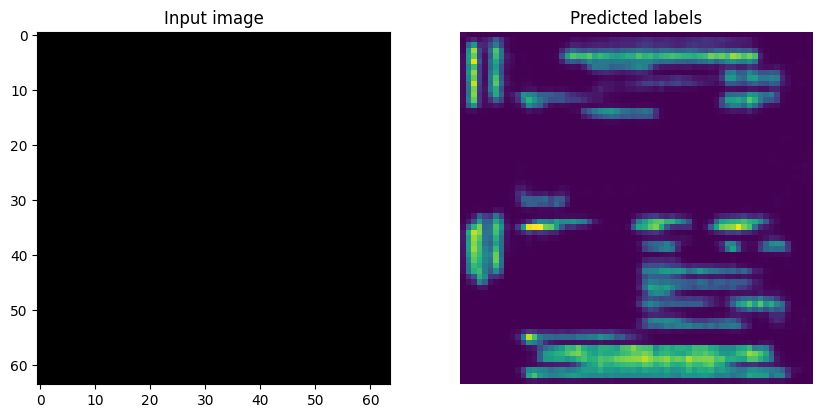

In [72]:
# plot the image
plt.savefig("../images/test_segmen.png")
# Show input image and predicted labels
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img[0])
axs[0].set_title('Input image')
axs[1].imshow(predictions[0])
axs[1].set_title('Predicted labels')
plt.axis("off")
plt.show()


# La transcription #
## Prétraitement: Load Images and Data Labels 



In [ ]:
#list of labels
Labeloutput = list(CNR_Data.glob("*_gt_ocr.txt"))
print(Labeloutput)

In [ ]:
import pandas as pd
#convert list of images to series (pandas)
CNH_Series = pd.Series(CNRinput,name="CNH_Aberta").astype(str)

In [ ]:
print(CNH_Series)

# Traitement de labels

## Conversion des fichiers texte en .csv

In [26]:
# text en .csv 

for f in list(CNR_Data.glob("*_gt_ocr.txt")):
  name_csv = str(f).replace('txt','csv')
  with open(f , encoding='latin-1') as infile, open(name_csv,'w') as outfile: 
        for line in infile: 
             outfile.write(line)

# Test pytesseract

In [ ]:
!sudo apt update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!sudo apt install tesseract-ocr-por

In [ ]:
!pip install pytesseract

In [17]:
import cv2
import pytesseract

# Set the path to the Tesseract executable and the location of the language data files
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
tessdata_dir_config = '--tessdata-dir "/usr/share/tesseract-ocr/4.00/tessdata"'

# Load the image
img = cv2.imread('./CNH_Aberta/00000000_in.jpg')

# Preprocess the image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform Text Region Segmentation
edges = cv2.Canny(gray, 100, 200)
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Extract the text regions
text_regions = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 50 and h > 50:
        text_regions.append((x, y, w, h))

# Perform OCR on each text region
for region in text_regions:
    x, y, w, h = region
    roi = gray[y:y+h, x:x+w]
    text = pytesseract.image_to_string(roi, lang='por', config=tessdata_dir_config)
    print(text)


Ê

  

Vad TRA Wa a

06/02/1972

  

 

 

RD
WIRTH PECCHIA SUZETE
a

TAISE VILLALOBOS CHRYSTIANO

 

   

x 206940361 sPTC 4 “co


 

 

 

 

 

